## Try XGBOOST as Forecats model for Crypto prediction

In [1]:
import pandas as pd
import xgboost
from matplotlib import pyplot as plt
#from sklearn import

In [610]:
data=pd.read_csv('data/ETH_histical_data.csv')
print(f'Dataset has {data.shape[0]} features and {data.shape[0]} historical values')
print(f'Data is collected from {str(data.date.min())} to {str(data.date.max())}')
data.info()

Dataset has 721 features and 721 historical values
Data is collected from 2019-08-23 to 2021-08-12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     721 non-null    object 
 1   open                     720 non-null    float64
 2   close                    721 non-null    float64
 3   high                     720 non-null    float64
 4   low                      720 non-null    float64
 5   volume                   720 non-null    float64
 6   market_cap               702 non-null    float64
 7   url_shares               716 non-null    float64
 8   unique_url_shares        716 non-null    float64
 9   reddit_posts             710 non-null    float64
 10  reddit_posts_score       710 non-null    float64
 11  reddit_comments          710 non-null    float64
 12  reddit_comments_score    710 non-nu

In [611]:
#Remove the columns that contains nan values only
nan_stat= (data.isnull().sum())
for col_name, val in nan_stat.items():
    if val>data.shape[0]*0.75:
        data.drop(columns=[col_name], inplace=True)

### Transform dataset for supervised learning

In [830]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, target, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, -1, -1):
        #print(i)
        #cols.append(pd.DataFrame(df.shift(i).values, columns=[col+'-'+str(i) for col in df.columns]))
        df_shift=df.shift(i)
        df_shift.columns=[col+'-'+str(i) for col in df_shift.columns]
        cols.append(df_shift)#df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    #for i in range(1, (n_out+1)):
    #    target_shift=target.shift(-i)
    #    print(i)
    #    #print(target_shift.head())
    #    cols.append(target_shift)#target.shift(-i))
    
    # forecast n_out step
    cols.append(target.shift(-n_out))

    # put it all together
    agg = pd.concat(cols, axis=1)

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg#.values

#Select features
#Select features excluding date
set_columns=data.columns[1:]
#select target feature
target_column='close'
#get features dataset
df=data[set_columns].fillna(0)
#get target vector
target=data[target_column]

#Run rtransformation to dataset for supervised learning
#n_in - number of historical lags to include in forecast
#n_out - number of lags predicted in future
#for example we want to predict 7 days in the future using history of last two weeks
#n_out=7, n_in=14
n_in=7
n_out=3
#Transform dataframe for supervised learning
res=series_to_supervised(df, target, n_in=n_in, n_out=n_out, dropnan=True)

In [831]:
#res[[x for x in res.columns if 'close' in x]].head()
#res.head()
#target
#res

In [832]:
#build xgboost prediction model
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
#Use the data with lag to predict the value in number of N_pred values in n_out steps
N_pred=30
train, test=train_test_split(res.values, N_pred)

testX, testy = test[:, :-n_out-1], test[:, -1]
trainX, trainy = train[:, :-n_out-1], train[:, -1]

# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [833]:
#trainX
testX.shape

(30, 461)

RMSE is 234.43476272190622


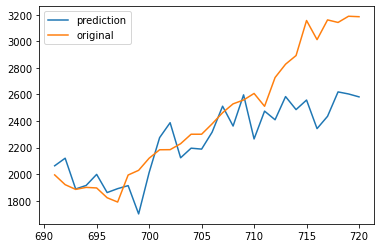

In [834]:
# make a prediction for test dataset
yhat = model.predict(np.asarray(testX))

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df=pd.Series(yhat, index=index_pred)
yhat_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
print(f'RMSE is {mean_absolute_error(testy, yhat)}')



In [835]:
#Find the most important features
#using the probability of influence
def features_importance_ratio(model, ratio=0.95):
    valuable_features=[i for i,v in enumerate(model.feature_importances_) if v > np.quantile(model.feature_importances_, ratio)]
    return [x for x in res.columns[valuable_features]]
#using the top N
import operator
def features_importance_top_N(model, topN=10):
    dict_features={}
    for i,v in enumerate(model.feature_importances_):
        dict_features[i]=v
    sorted_d = dict( sorted(dict_features.items(), key=operator.itemgetter(1),reverse=True))
    valuable_features=list(sorted_d.keys())[:topN]
    return [x for x in res.columns[valuable_features]]
#Get the most valuable features
#features=features_importance_ratio(model, ratio=0.95)
#features=features_importance_top_N(model, topN=6)



In [836]:
#print('List of selected features based on the selected thrshhold of importance')
#features=features_importance_top_N(model, topN=6)
#features

RMSE is 245.70364142413544


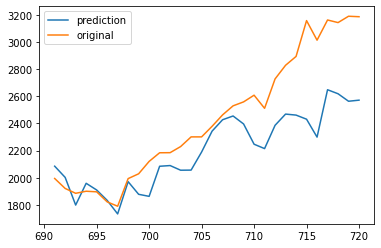

In [837]:
features=features_importance_ratio(model, ratio=0.95)
## Train with selected highly important features only
trainX_feat, testX_feat=train_test_split(res[features].values, N_pred) 
# fit model
modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelf.fit(trainX_feat, trainy)
# make a prediction for test dataset
yhat = modelf.predict(np.asarray(testX_feat))

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df=pd.Series(yhat, index=index_pred)
yhat_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
print(f'RMSE is {mean_absolute_error(testy, yhat)}')

RMSE is 252.28070555676044


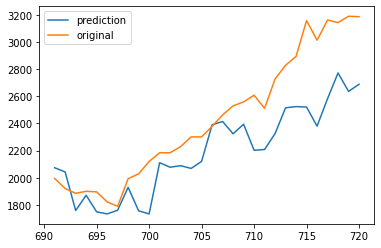

In [838]:
#try SelectFromModel sklearn approach for feature selection
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(model, prefit=True)
select_X_train = selector.transform(trainX)
# train model
selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
selection_model.fit(select_X_train, trainy)
# eval model
select_X_test = selector.transform(testX)
y_pred = selection_model.predict(select_X_test)
predictions = [(value) for value in y_pred]
pred_df=pd.Series(predictions, index=index_pred)
pred_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
print(f'RMSE is {mean_absolute_error(testy, predictions)}')

In [839]:
## Check if the error can be decreased using different threshholds of feature importance
from sklearn.metrics import accuracy_score
thresholds = np.sort(model.feature_importances_)
feature_factor=dict()
for thresh in np.unique(thresholds)[-50:]:
    #print(thresh)
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(trainX)
    # train model
    selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    selection_model.fit(select_X_train, trainy)
    # eval model
    select_X_test = selection.transform(testX)
    y_pred = selection_model.predict(select_X_test)
    predictions = [(value) for value in y_pred]
    mae = mean_absolute_error(testy, predictions)
    #print("Thresh=%.5f, n=%d, MAE: %.3f" % (thresh, select_X_train.shape[1], mae))
    feature_factor[select_X_train.shape[1]]=mae
print(min(feature_factor, key=feature_factor.get))

35


In [840]:
print('List of selected features based on the selected thrshhold of importance')
features=features_importance_top_N(model, topN=min(feature_factor, key=feature_factor.get))
print(features)


List of selected features based on the selected thrshhold of importance
['low-7', 'low-3', 'high-0', 'low-6', 'high-3', 'close-7', 'reddit_posts-1', 'market_cap-3', 'reddit_comments-6', 'low-0', 'market_cap_global-1', 'high-2', 'market_cap_global-4', 'close-0', 'open-4', 'market_cap_global-5', 'reddit_comments-7', 'reddit_posts-4', 'market_cap_global-7', 'social_volume_global-4', 'close-1', 'open-0', 'market_cap-2', 'open-6', 'price_btc-4', 'market_cap-0', 'close-3', 'market_dominance-7', 'social_contributors-4', 'social_contributors-7', 'tweet_sentiment4-1', 'market_cap_global-2', 'youtube-6', 'alt_rank_30d-0', 'market_cap_global-6']


List of selected features based on the selected thrshhold of importance
['low-7', 'low-3', 'high-0', 'low-6', 'high-3', 'close-7', 'reddit_posts-1', 'market_cap-3', 'reddit_comments-6', 'low-0', 'market_cap_global-1', 'high-2', 'market_cap_global-4', 'close-0', 'open-4', 'market_cap_global-5', 'reddit_comments-7', 'reddit_posts-4', 'market_cap_global-7', 'social_volume_global-4', 'close-1', 'open-0', 'market_cap-2', 'open-6', 'price_btc-4', 'market_cap-0', 'close-3', 'market_dominance-7', 'social_contributors-4', 'social_contributors-7', 'tweet_sentiment4-1', 'market_cap_global-2', 'youtube-6', 'alt_rank_30d-0', 'market_cap_global-6']
RMSE is 192.621482189625


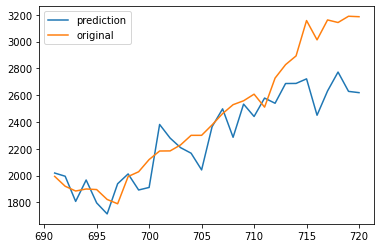

In [841]:
#features=features_importance_top_N(model, topN=len(features))
print('List of selected features based on the selected thrshhold of importance')
print(features)
## Train and test model with selected features only
trainX_feat, testX_feat=train_test_split(res[features].values, N_pred) 
# fit model
modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelf.fit(trainX_feat, trainy)
# make a prediction for test dataset
yhat = modelf.predict(np.asarray(testX_feat))

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df=pd.Series(yhat, index=index_pred)
yhat_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
print(f'RMSE is {mean_absolute_error(testy, yhat)}')

Historical data of close value


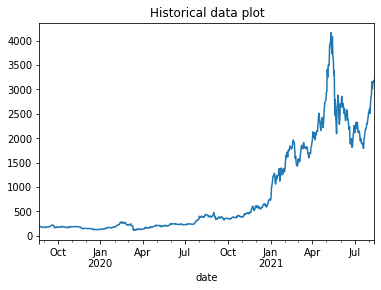

Features in Original dataset open, close, high, low, volume, market_cap, url_shares, unique_url_shares, reddit_posts, reddit_posts_score, reddit_comments, reddit_comments_score, tweets, tweet_spam, tweet_followers, tweet_quotes, tweet_retweets, tweet_replies, tweet_favorites, tweet_sentiment1, tweet_sentiment2, tweet_sentiment3, tweet_sentiment4, tweet_sentiment5, tweet_sentiment_impact1, tweet_sentiment_impact2, tweet_sentiment_impact3, tweet_sentiment_impact4, tweet_sentiment_impact5, social_score, average_sentiment, sentiment_absolute, sentiment_relative, search_average, news, price_score, social_impact_score, correlation_rank, galaxy_score, volatility, alt_rank, alt_rank_30d, alt_rank_hour_average, market_cap_rank, percent_change_24h_rank, volume_24h_rank, social_volume_24h_rank, social_score_24h_rank, medium, youtube, social_contributors, social_volume, price_btc, social_volume_global, social_dominance, percent_change_24h, market_cap_global, market_dominance
Target of prediction c

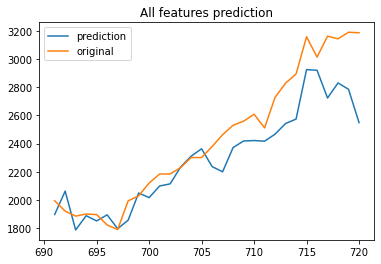

RMSE of model with all features is 164.4521549255625
List of selected features based on the selected thrshhold of importance
['low-9', 'low-3', 'low-0', 'market_cap_global-0', 'market_cap_global-14', 'high-0', 'low-14', 'open-0', 'close-0', 'market_cap_global-7', 'market_cap_global-6']


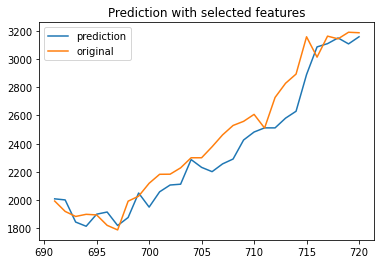

RMSE is 105.60315939011461


In [852]:
#put all together

#prepare dataset with parameters
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

from sklearn.metrics import accuracy_score

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, target, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, -1, -1):
        #print(i)
        #cols.append(pd.DataFrame(df.shift(i).values, columns=[col+'-'+str(i) for col in df.columns]))
        df_shift=df.shift(i)
        df_shift.columns=[col+'-'+str(i) for col in df_shift.columns]
        cols.append(df_shift)#df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    #for i in range(1, (n_out+1)):
    #    target_shift=target.shift(-i)
    #    print(i)
    #    #print(target_shift.head())
    #    cols.append(target_shift)#target.shift(-i))
    
    # forecast n_out step
    cols.append(target.shift(-n_out))

    # put it all together
    agg = pd.concat(cols, axis=1)

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg#.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

#Find the most important features
#using the probability of influence
def features_importance_ratio(model, ratio=0.95):
    valuable_features=[i for i,v in enumerate(model.feature_importances_) if v > np.quantile(model.feature_importances_, ratio)]
    return [x for x in res.columns[valuable_features]]
#using the top N
import operator
def features_importance_top_N(model, topN=10):
    dict_features={}
    for i,v in enumerate(model.feature_importances_):
        dict_features[i]=v
    sorted_d = dict( sorted(dict_features.items(), key=operator.itemgetter(1),reverse=True))
    valuable_features=list(sorted_d.keys())[:topN]
    return [x for x in res.columns[valuable_features]]

def get_N_features_dict(model):
    thresholds = np.sort(model.feature_importances_)
    feature_factor=dict()
    for thresh in np.unique(thresholds)[-50:]:
        #print(thresh)
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(trainX)
        # train model
        selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        selection_model.fit(select_X_train, trainy)
        # eval model
        select_X_test = selection.transform(testX)
        y_pred = selection_model.predict(select_X_test)
        predictions = [(value) for value in y_pred]
        mae = mean_absolute_error(testy, predictions)
        #print("Thresh=%.5f, n=%d, MAE: %.3f" % (thresh, select_X_train.shape[1], mae))
        feature_factor[select_X_train.shape[1]]=mae
    #print(min(feature_factor, key=feature_factor.get))
    return feature_factor



#Select features
#Select features excluding date
set_columns=data.columns[1:]
#select target feature
target_column='close'
#get features dataset
df=data[set_columns].fillna(0)
#get target vector
target=data[target_column]

#Run rtransformation to dataset for supervised learning
#n_in - number of historical lags to include in forecast
#n_out - number of lags predicted in future
#for example we want to predict 7 days in the future using history of last two weeks
#n_out=7, n_in=14
n_in=14
n_out=1

set_columns_list=', '.join(set_columns)
print(f'Historical data of {target_column} value')
pd.Series(data[target_column].values, index=pd.DatetimeIndex(data.date)).plot(title='Historical data plot')
plt.show()

print(f'Features in Original dataset {set_columns_list}')
print(f'Target of prediction {target_column}')
#Transform dataframe for supervised learning
res=series_to_supervised(df, target, n_in=n_in, n_out=n_out, dropnan=True)

print(f'Prediction is build using last {n_in} days of historical data')
print(f'Prediction is build for {n_out} day ahead')

#build xgboost prediction model
#Use the data with lag to predict the value in number of N_pred values in n_out steps
N_pred=30
train, test=train_test_split(res.values, N_pred)

testX, testy = test[:, :-n_out-1], test[:, -1]
trainX, trainy = train[:, :-n_out-1], train[:, -1]

# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

# make a prediction for test dataset
yhat = model.predict(np.asarray(testX))

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df=pd.Series(yhat, index=index_pred)
yhat_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
plt.title('All features prediction')
plt.show()
print(f'RMSE of model with all features is {mean_absolute_error(testy, yhat)}')


## Check if the error can be decreased using different threshholds of feature importance
feature_factor=get_N_features_dict(model)
print('List of selected features based on the selected thrshhold of importance')
features=features_importance_top_N(model, topN=min(feature_factor, key=feature_factor.get))
print(features)

#Train and test on the most valuable features only
## Train and test model with selected features only
trainX_feat, testX_feat=train_test_split(res[features].values, N_pred) 
# fit model
modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelf.fit(trainX_feat, trainy)
# make a prediction for test dataset
yhat = modelf.predict(np.asarray(testX_feat))

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df=pd.Series(yhat, index=index_pred)
yhat_df.plot(label='prediction')
#pd.Series(testy, index=index_pred).plot(label='expected')

df.loc[index_pred]['close'].plot(label='original')
plt.legend()
plt.title('Prediction with selected features')
plt.show()
print(f'RMSE is {mean_absolute_error(testy, yhat)}')

In [850]:
data

,date,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,...,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance
0,2019-08-23,194.095452,193.557766,197.116324,191.043475,4.137593e+09,NaN,NaN,NaN,104.0,...,NaN,NaN,3073.0,799,0.018687,10418,7.669418,1.450014,NaN,NaN
1,2019-08-24,190.228561,190.941977,192.920571,187.620900,4.304113e+09,NaN,NaN,NaN,54.0,...,NaN,NaN,2685.0,578,0.018817,5924,9.756921,-1.351425,NaN,NaN
2,2019-08-25,190.331654,186.402552,191.233840,184.956128,3.992479e+09,NaN,NaN,NaN,61.0,...,NaN,NaN,2316.0,222,0.018415,2815,7.886323,-2.377385,NaN,NaN
3,2019-08-26,190.453129,188.952688,193.399134,187.481839,4.503988e+09,NaN,NaN,NaN,73.0,...,NaN,NaN,2464.0,256,0.018191,2875,8.904348,1.368080,NaN,NaN
4,2019-08-27,185.231741,186.892907,188.883682,184.086398,3.929909e+09,NaN,NaN,NaN,71.0,...,NaN,NaN,1450.0,264,0.018397,2943,8.970438,-1.090104,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2021-08-08,3156.562589,3012.801443,3181.302808,2955.336225,4.931145e+10,3.704350e+11,19450.0,6489.0,NaN,...,15.0,NaN,57648.0,69964,0.068759,1127022,6.207865,-4.565876,1.904404e+12,19.451494
717,2021-08-09,3012.459626,3161.493066,3180.616685,2911.891615,5.569610e+10,3.443581e+11,16449.0,7285.0,NaN,...,17.0,2.0,65544.0,84163,0.068320,1226395,6.862634,4.935328,1.995950e+12,17.252848
718,2021-08-10,3160.835310,3142.309813,3229.122796,3059.119366,4.481658e+10,3.660722e+11,21152.0,8219.0,186.0,...,20.0,11.0,84836.0,100140,0.068911,1139561,8.787595,-0.606778,1.998478e+12,18.317553
719,2021-08-11,3144.397682,3189.037631,3273.305042,3131.515334,3.497735e+10,3.707247e+11,32566.0,9607.0,1031.0,...,15.0,7.0,80585.0,112093,0.069502,1271155,8.818201,1.487053,2.036888e+12,18.200547


### Continue to explore predicting each day and adding it value for one step forward forecast

In [65]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions
 
    
sup_data=series_to_supervised(data[['close']], n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(sup_data, 12)

/opt/anaconda3/envs/python3_env/lib/python3.7/site-packages/xgboost/core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


>expected=14.9, predicted=16.7
>expected=14.2, predicted=16.6
>expected=13.8, predicted=15.6
>expected=13.1, predicted=15.0
>expected=12.1, predicted=13.9
>expected=12.3, predicted=12.5
>expected=12.7, predicted=12.4
>expected=11.5, predicted=12.7
>expected=11.0, predicted=11.7
>expected=12.4, predicted=11.5
>expected=13.2, predicted=12.0
>expected=12.5, predicted=12.5


In [43]:
data.tail()

,date,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,...,medium,youtube,social_contributors,price_btc,percent_change_24h,social_volume,social_volume_global,social_dominance,market_cap_global,market_dominance
340,2021-07-19,12.659186,11.495162,12.756441,11.391805,9.353971e+08,1.256179e+10,332.0,198.0,14.0,...,NaN,NaN,2774.0,0.000372,-9.279229,3738.0,1058660.0,0.353088,1.378915e+12,0.910991
341,2021-07-20,11.480408,10.982207,11.559666,10.403210,1.032411e+09,1.149260e+10,488.0,268.0,11.0,...,NaN,1.0,5699.0,0.000368,-4.462353,6713.0,1085896.0,0.618199,1.319836e+12,0.870760
342,2021-07-21,10.989894,12.362557,12.858393,10.742165,1.404588e+09,1.085993e+10,250.0,185.0,3.0,...,NaN,NaN,2591.0,0.000384,12.568964,3121.0,1236175.0,0.252472,1.433972e+12,0.757332
343,2021-07-22,12.375220,13.182885,13.384020,11.857660,1.245650e+09,1.231380e+10,274.0,204.0,17.0,...,NaN,NaN,4203.0,0.000407,6.635583,4538.0,1109318.0,0.409080,1.446023e+12,0.851563
344,2021-07-23,13.171055,12.543549,13.529863,12.391981,7.787467e+08,1.332177e+10,239.0,190.0,9.0,...,NaN,NaN,2331.0,0.000386,-3.230000,2409.0,1063838.0,0.226444,1.435831e+12,0.927809


In [39]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]